# Deep Learning with Titanic Dataset

In [3]:
# Data manipulation
import pandas as pd 
import numpy as np 

# For preprocessing data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

## Plotting data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

## Preparing the data

In [4]:
# Load data
df = pd.read_csv('train.csv')
print(df.columns)
print(len(df))
df.describe()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
891


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
def format_feats(in_feats):
    x = in_feats.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=in_feats.columns)

# Apply some data formatting
def format_data(data):
    # One-hot encode 'Embarked' column
    data = pd.get_dummies(data, columns=['Sex','Embarked'])
    # Drop columns that require additional processing
    data = data.drop(['Name','Ticket','Cabin'], axis=1)
    # Fill null values with the mean of the column
    data.fillna(data.mean(), inplace=True)
    if 'Survived' in data.columns:
        data_y = data['Survived']
        data_x = data.drop(['Survived'], axis=1)
        data_x = format_feats(data_x)
        print('found it')
        return data_x, data_y
    else:
        return format_feats(data)

# This should split the data into our features and our labels
feats, labels = format_data(df)
feats.describe()

found it


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.500000,0.654321,0.367921,0.065376,0.063599,0.062858,0.352413,0.647587,0.188552,0.086420,0.722783
std,0.289162,0.418036,0.163383,0.137843,0.134343,0.096995,0.477990,0.477990,0.391372,0.281141,0.447876
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.500000,0.271174,0.000000,0.000000,0.015440,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,1.000000,0.367921,0.000000,0.000000,0.028213,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.750000,1.000000,0.434531,0.125000,0.000000,0.060508,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Splitting between validation and training
X_train, X_validation, Y_train, Y_validation = train_test_split(feats, labels, test_size = 0.1)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.3)

In [7]:
X_train = torch.FloatTensor(X_train.to_numpy())
Y_train = torch.LongTensor(Y_train.to_numpy())

X_test = torch.FloatTensor(X_test.to_numpy())
Y_test = torch.LongTensor(Y_test.to_numpy())

X_validation = torch.FloatTensor(X_validation.to_numpy())
Y_validation = torch.LongTensor(Y_validation.to_numpy())

## Neural Network

In [8]:
class Classifier(nn.Module):
    def __init__(self, input_feat, output_feat):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_feat, 250) 
        self.fc2 = nn.Linear(250, output_feat)
    
    def forward(self, x):        
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x))
        return x

model = Classifier(input_feat=X_train.size()[1], output_feat=2)
model

Classifier(
  (fc1): Linear(in_features=11, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=2, bias=True)
)

In [9]:
model = Classifier(input_feat=X_train.size()[1], output_feat=2)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# number of epochs to train the model
n_epochs = 5

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to +infinity

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_train)//10)))

        lower_bound_index = upper_bound_index

        x = X_train[index_range]
        y = Y_train[index_range]

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*X_train.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_validation)//10)))

        lower_bound_index = upper_bound_index

        x = X_validation[index_range]
        y = Y_validation[index_range]

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y) 
        # update running validation loss 
        valid_loss += loss.item()*X_validation.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(X_train)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(X_validation)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 5.208287 	Validation Loss: 5.784084
Validation loss decreased (inf --> 5.784084).  Saving model ...
Epoch: 2 	Training Loss: 4.336091 	Validation Loss: 4.775272
Validation loss decreased (5.784084 --> 4.775272).  Saving model ...
Epoch: 3 	Training Loss: 4.147239 	Validation Loss: 4.786258
Epoch: 4 	Training Loss: 4.013034 	Validation Loss: 4.556045
Validation loss decreased (4.775272 --> 4.556045).  Saving model ...
Epoch: 5 	Training Loss: 3.916784 	Validation Loss: 4.462741
Validation loss decreased (4.556045 --> 4.462741).  Saving model ...


In [10]:
model = Classifier(X_train.size()[1], 2)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [11]:
# initialize lists to monitor test loss and accuracy
test_loss = 0
accuracy = 0
test_losses = []

model.eval() # prepare model for evaluation
# To speed up calculations, forget the gradients, etc.
with torch.no_grad():
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_validation)//10)))

        lower_bound_index = upper_bound_index

        x = X_test[index_range]
        y = Y_test[index_range]
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y)
        # update test loss 
        test_loss += loss.item()*x.size(0)
        test_losses.append(test_loss)

        ps = torch.exp(output) # cuz our model outputs log-probability
        top_p, top_class = ps.topk(1, dim = 1)

        equals = (top_class == y.view(*top_class.shape))
        accuracy += torch.mean(equals.type(torch.FloatTensor))/(len(range(1,11)))

        print("Test Loss: {:.3f}.. ".format(test_loss/len(X_test)),
              "Test Accuracy: {:.3f}".format(accuracy))

Test Loss: 0.007..  Test Accuracy: 0.100
Test Loss: 0.033..  Test Accuracy: 0.182
Test Loss: 0.064..  Test Accuracy: 0.266
Test Loss: 0.115..  Test Accuracy: 0.345
Test Loss: 0.172..  Test Accuracy: 0.428
Test Loss: 0.246..  Test Accuracy: 0.512
Test Loss: 0.353..  Test Accuracy: 0.592
Test Loss: 0.468..  Test Accuracy: 0.676
Test Loss: 0.593..  Test Accuracy: 0.758
Test Loss: 0.743..  Test Accuracy: 0.838


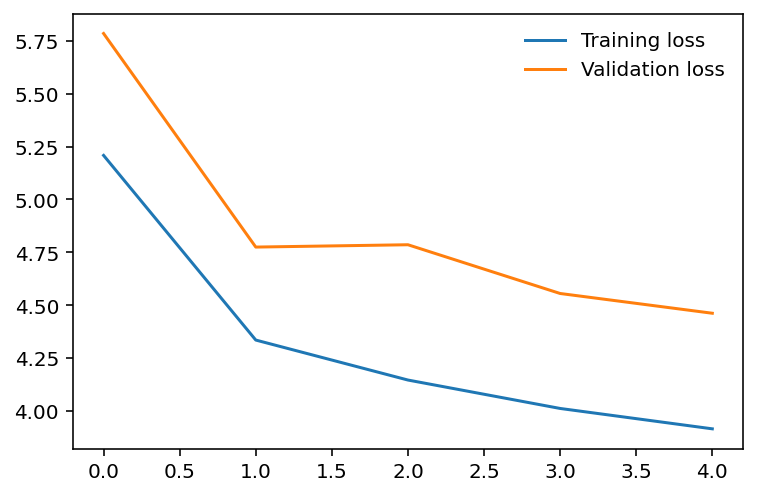

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)